Starting simulation with further revised parameters...
Time: 0 min | True G: 121.5 | Measured G: 129.0 | EKF G Est: 128.5 | Insulin Del: 2.00
Time: 100 min | True G: 112.8 | Measured G: 114.6 | EKF G Est: 113.8 | Insulin Del: 0.50
Time: 200 min | True G: 114.6 | Measured G: 111.7 | EKF G Est: 114.9 | Insulin Del: 0.50

Simulation finished.


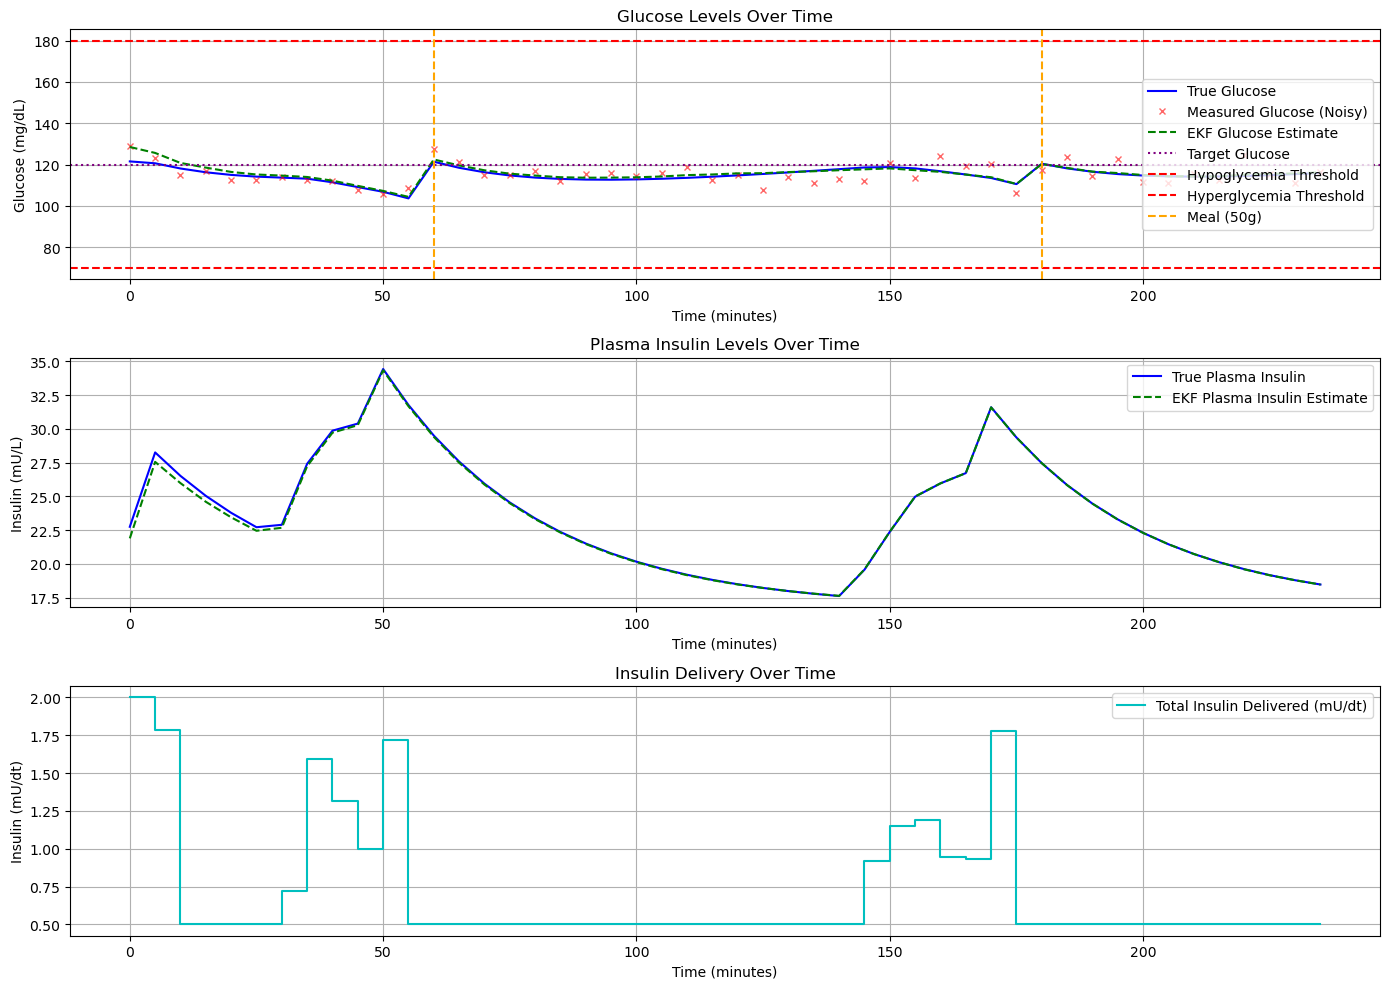

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- 1. Simplified Glucose-Insulin Model (Nonlinear) ---
# This is a highly simplified, hypothetical model for demonstration.
# It's a two-state model: [glucose (mg/dL), insulin_in_plasma (mU/L)]
# Glucose dynamics are influenced by insulin and a constant production rate.
# Insulin dynamics are influenced by insulin delivery and clearance.

# Parameters for the "true" patient model (unknown to the EKF/MPC)
# These values are illustrative and tuned for a physiologically plausible simulation.
TRUE_PARAMS = {
    'k_g_insulin': 0.0005,  # Insulin effect on glucose uptake
    'k_g_base': 1.2,        # Basal glucose production/utilization
    'k_i_clear': 0.03,      # Insulin clearance rate
    'meal_effect_rate': 0.08, # Rate at which meal carbs enter glucose pool 
    'initial_glucose': 120, # Starting glucose in a healthy range
    'initial_insulin': 15,  # Starting insulin in a reasonable range
}

def glucose_insulin_model(state, insulin_delivery, meal_carbs, dt, params):
    """
    Simulates the glucose-insulin dynamics over a small time step dt.
    state: [glucose (mg/dL), insulin_in_plasma (mU/L)]
    insulin_delivery: insulin delivered in this time step (mU)
    meal_carbs: carbohydrates absorbed in this time step (g)
    dt: time step (minutes)
    params: dictionary of model parameters
    """
    glucose, insulin_plasma = state

    # Extract parameters
    k_g_insulin = params['k_g_insulin']
    k_g_base = params['k_g_base']
    k_i_clear = params['k_i_clear']
    meal_effect_rate = params['meal_effect_rate']

    # Glucose dynamics (simplified nonlinear)
    # Glucose decreases with insulin, increases with basal production and meal absorption
    # The term `insulin_plasma * glucose` makes it nonlinear, simulating insulin's
    # effect being proportional to both insulin concentration and available glucose.
    d_glucose_dt = -k_g_insulin * insulin_plasma * glucose + k_g_base + meal_effect_rate * meal_carbs
    
    # Insulin dynamics
    # Insulin increases with delivery, decreases with clearance
    d_insulin_plasma_dt = insulin_delivery - k_i_clear * insulin_plasma

    # Update states
    new_glucose = glucose + d_glucose_dt * dt
    new_insulin_plasma = insulin_plasma + d_insulin_plasma_dt * dt

    # Ensure states remain physiological (non-negative, and prevent extreme values)
    new_glucose = max(30.0, new_glucose) # Prevent going too low, but allow some drop below target
    new_insulin_plasma = max(0.1, new_insulin_plasma)

    return np.array([new_glucose, new_insulin_plasma])

# --- 2. Extended Kalman Filter (EKF) Implementation ---
# The EKF will estimate the true state [glucose, insulin_in_plasma]
# from noisy glucose measurements.

class EKF:
    def __init__(self, initial_state_estimate, initial_covariance, process_noise_cov, measurement_noise_cov, model_params, dt):
        """
        Initializes the EKF.
        initial_state_estimate: Initial guess for the state [glucose, insulin_plasma]
        initial_covariance: Initial covariance matrix P
        process_noise_cov: Q - covariance of the process noise
        measurement_noise_cov: R - covariance of the measurement noise
        model_params: Parameters for the glucose-insulin model used by EKF
        dt: Time step for the model
        """
        self.x_hat = initial_state_estimate  # State estimate [glucose, insulin_plasma]
        self.P = initial_covariance         # Covariance matrix
        self.Q = process_noise_cov          # Process noise covariance
        self.R = measurement_noise_cov      # Measurement noise covariance
        self.model_params = model_params
        self.dt = dt

    def predict(self, insulin_delivery, meal_carbs):
        """
        EKF Prediction Step: Project the state and covariance forward in time.
        """
        # 1. Predict the next state using the nonlinear model
        self.x_hat = glucose_insulin_model(self.x_hat, insulin_delivery, meal_carbs, self.dt, self.model_params)

        # 2. Compute the Jacobian of the process model (F)
        # F_ij = d(f_i)/d(x_j) where f is the state transition function
        # x = [glucose, insulin_plasma]
        # f1 = glucose + dt * (-k_g_insulin * insulin_plasma * glucose + k_g_base + meal_effect_rate * meal_carbs)
        # f2 = insulin_plasma + dt * (insulin_delivery - k_i_clear * insulin_plasma)

        g, i_p = self.x_hat
        k_g_insulin = self.model_params['k_g_insulin']
        k_i_clear = self.model_params['k_i_clear']

        F = np.array([
            [1 + self.dt * (-k_g_insulin * i_p), self.dt * (-k_g_insulin * g)],
            [0, 1 + self.dt * (-k_i_clear)]
        ])

        # 3. Predict the next covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z_measured):
        """
        EKF Update Step: Correct the predicted state and covariance using a measurement.
        z_measured: The noisy glucose measurement
        """
        # 1. Measurement function (h): In this case, we only measure glucose.
        # h(x) = [glucose]
        
        # 2. Compute the Jacobian of the measurement model (H)
        # H_ij = d(h_i)/d(x_j)
        H = np.array([[1, 0]]) # We measure glucose (first state) directly

        # 3. Calculate the innovation (measurement residual)
        y = np.array([z_measured - (H @ self.x_hat)[0]]) 

        # 4. Calculate the innovation (or residual) covariance
        S = H @ self.P @ H.T + self.R

        # 5. Calculate the Kalman Gain
        K = self.P @ H.T @ np.linalg.inv(S)

        # 6. Update the state estimate
        self.x_hat = self.x_hat + K @ y

        # Ensure states remain physiological after update
        self.x_hat[0] = max(30.0, self.x_hat[0]) # Glucose
        self.x_hat[1] = max(0.1, self.x_hat[1]) # Insulin

        # 7. Update the covariance matrix
        I = np.eye(self.P.shape[0]) # Identity matrix
        self.P = (I - K @ H) @ self.P

# --- 3. Model Predictive Control (MPC) Implementation ---

class MPC:
    def __init__(self, prediction_horizon, control_horizon, dt, model_params, target_glucose):
        """
        Initializes the MPC controller.
        prediction_horizon: Number of future time steps to predict (Np)
        control_horizon: Number of future control inputs to optimize (Nc <= Np)
        dt: Time step for the model
        model_params: Parameters for the glucose-insulin model used by MPC
        target_glucose: Desired glucose level (mg/dL)
        """
        self.Np = prediction_horizon # Prediction Horizon
        self.Nc = control_horizon    # Control Horizon
        self.dt = dt
        self.model_params = model_params
        self.target_glucose = target_glucose

        # Constraints on insulin delivery (mU per dt)
        self.min_insulin_delivery = 0.0 # Cannot deliver negative insulin
        self.max_insulin_delivery = 1.5 # Max bolus per dt

    def objective_function(self, u_sequence, current_state_estimate, meal_plan):
        """
        Objective function for the MPC optimization.
        Minimizes deviation from target glucose and penalizes large insulin changes.
        u_sequence: Sequence of insulin delivery rates to optimize [u_0, u_1, ..., u_{Nc-1}]
        current_state_estimate: EKF's current best estimate of the state [glucose, insulin_plasma]
        meal_plan: Predicted future meal carbs [meal_0, meal_1, ..., meal_{Np-1}]
        """
        J = 0.0
        current_sim_state = np.copy(current_state_estimate)
        
        # Penalize insulin changes (smoothness)
        # Assume u_sequence[0] is the current change, and previous_u is 0 for simplicity here
        # In a more advanced MPC, you'd track the previous actual insulin delivery
        if len(u_sequence) > 1:
            J += 0.1 * np.sum(np.diff(u_sequence)**2) # Penalize changes in insulin delivery

        for k in range(self.Np):
            # Apply control input (u_sequence) for the control horizon (Nc)
            # After Nc, assume constant last control input
            insulin_input = u_sequence[min(k, self.Nc - 1)]
            
            # Get meal input for current prediction step
            meal_input = meal_plan[k] if k < len(meal_plan) else 0.0

            # Simulate the model forward
            current_sim_state = glucose_insulin_model(current_sim_state, insulin_input, meal_input, self.dt, self.model_params)
            
            # Get predicted glucose
            predicted_glucose = current_sim_state[0]

            # Add to objective: squared error from target glucose
            J += (predicted_glucose - self.target_glucose)**2
            
            # Add a strong penalty for severe hypoglycemia in prediction horizon
            if predicted_glucose < 70:
                J += 5000 * (70 - predicted_glucose)**2 # Even stronger penalty for low glucose
            
        return J

    def calculate_optimal_insulin(self, current_state_estimate, meal_plan):
        """
        Calculates the optimal insulin delivery for the current time step.
        """
        # Initial guess for control inputs (e.g., zero insulin delivery)
        u0 = np.zeros(self.Nc)

        # Bounds for insulin delivery
        bounds = [(self.min_insulin_delivery, self.max_insulin_delivery) for _ in range(self.Nc)]

        # Optimization
        # Using SLSQP, a sequential least squares programming algorithm.
        # It's suitable for constrained nonlinear optimization.
        result = minimize(
            self.objective_function,
            u0,
            args=(current_state_estimate, meal_plan),
            method='SLSQP',
            bounds=bounds,
            options={'disp': False, 'maxiter': 50} # maxiter can be adjusted for performance vs accuracy
        )

        if result.success:
            # Return the first optimal control input
            return result.x[0]
        else:
            # Fallback in case optimization fails (e.g., return a default basal or zero)
            print(f"MPC optimization failed: {result.message}. Returning 0 insulin.")
            return 0.0

# --- 4. Simulation Loop ---

def run_simulation():
    total_simulation_time = 240 # minutes (4 hours)
    dt = 5                      # minutes (control interval, CGM reading interval)
    num_steps = int(total_simulation_time / dt)

    # --- True System Initialization ---
    true_state = np.array([TRUE_PARAMS['initial_glucose'], TRUE_PARAMS['initial_insulin']])
    
    # --- EKF Initialization ---
    # EKF's initial guess (can be slightly off from true)
    ekf_initial_state_estimate = np.array([TRUE_PARAMS['initial_glucose'] + 5, TRUE_PARAMS['initial_insulin'] - 1])
    ekf_initial_covariance = np.diag([10**2, 1**2]) # Initial uncertainty (glucose, insulin)

    # EKF Process Noise (Q): Uncertainty in the model's dynamics
    # Higher values mean more trust in measurements, lower in model.
    ekf_process_noise_cov = np.diag([0.5**2, 0.1**2]) 
    
    # EKF Measurement Noise (R): Uncertainty in the CGM readings
    ekf_measurement_noise_cov = np.array([[5**2]]) # CGM noise (e.g., 5 mg/dL standard deviation)

    # EKF's model parameters (can be slightly different from true for robustness test)
    # For a robust EKF, these parameters would ideally be estimated or adapted over time.
    # For this demo, we'll assume they are close to the true parameters.
    ekf_model_params = {
        'k_g_insulin': 0.0005,
        'k_g_base': 1.2,
        'k_i_clear': 0.03,
        'meal_effect_rate': 0.08,
    }

    ekf_filter = EKF(ekf_initial_state_estimate, ekf_initial_covariance,
                     ekf_process_noise_cov, ekf_measurement_noise_cov,
                     ekf_model_params, dt)

    # --- MPC Initialization ---
    mpc_prediction_horizon = 12 # Predict 12 steps * 5 min/step = 60 minutes ahead
    mpc_control_horizon = 3   # Optimize 3 insulin inputs (15 minutes)
    mpc_target_glucose = 120 # mg/dL

    # MPC's model parameters (should ideally match EKF's model parameters)
    mpc_model_params = ekf_model_params 

    mpc_controller = MPC(mpc_prediction_horizon, mpc_control_horizon, dt,
                         mpc_model_params, mpc_target_glucose)

    # --- Simulation Data Storage ---
    time_points = np.arange(0, total_simulation_time, dt)
    true_glucose_history = []
    true_insulin_history = []
    measured_glucose_history = []
    ekf_glucose_estimate_history = []
    ekf_insulin_estimate_history = []
    insulin_delivery_history = []
    
    # --- Meal Schedule (Hypothetical) ---
    # Meals are instantaneous for simplicity here. In reality, absorption is modeled.
    # (time_min, carbs_grams)
    meals = {
        60: 50,  # 50g carbs at 60 minutes (a moderate meal)
        180: 30 # 30g carbs at 180 minutes (a smaller snack)
    }

    # --- Simulation Loop ---
    print("Starting simulation with further revised parameters...")
    for i in range(num_steps):
        current_time = i * dt
        
        # 1. Get meal input for current time step
        current_meal_carbs = meals.get(current_time, 0)

        # 2. True System Evolution (Simulate the real patient)
        # We assume some basal insulin is always delivered by the pump,
        # plus the MPC-calculated bolus.
        # A fixed basal of 0.1 mU/min * dt (5 min) = 0.5 mU per dt
        basal_insulin = 0.5 
        
        # --- MPC Calculates Optimal Insulin ---
        # The MPC needs to know the EKF's current state estimate and future meal predictions.
        
        # Create a future meal plan for the MPC's prediction horizon
        # For simplicity, assume MPC knows future meals perfectly in this example.
        # In a real system, this would come from user input or a meal detection algorithm.
        future_meal_plan = []
        for j in range(mpc_prediction_horizon):
            future_time = current_time + (j + 1) * dt
            future_meal_plan.append(meals.get(future_time, 0))

        # Calculate optimal insulin delivery (this is the bolus part)
        optimal_bolus = mpc_controller.calculate_optimal_insulin(
            ekf_filter.x_hat, future_meal_plan
        )
        
        total_insulin_delivered = basal_insulin + optimal_bolus
        
        true_state = glucose_insulin_model(true_state, total_insulin_delivered, current_meal_carbs, dt, TRUE_PARAMS)

        # 3. Generate Noisy Glucose Measurement (from CGM)
        # Add Gaussian noise to the true glucose value
        measured_glucose = true_state[0] + np.random.normal(0, np.sqrt(ekf_filter.R[0,0]))

        # 4. EKF Prediction Step
        ekf_filter.predict(total_insulin_delivered, current_meal_carbs)

        # 5. EKF Update Step
        ekf_filter.update(measured_glucose)

        # 6. Store Data
        true_glucose_history.append(true_state[0])
        true_insulin_history.append(true_state[1])
        measured_glucose_history.append(measured_glucose)
        ekf_glucose_estimate_history.append(ekf_filter.x_hat[0])
        ekf_insulin_estimate_history.append(ekf_filter.x_hat[1])
        insulin_delivery_history.append(total_insulin_delivered)

        if i % 20 == 0: # Print update every 100 minutes
            print(f"Time: {current_time} min | True G: {true_state[0]:.1f} | Measured G: {measured_glucose:.1f} | EKF G Est: {ekf_filter.x_hat[0]:.1f} | Insulin Del: {total_insulin_delivered:.2f}")

    print("\nSimulation finished.")

    # --- Plotting Results ---
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    plt.plot(time_points, true_glucose_history, 'b-', label='True Glucose')
    plt.plot(time_points, measured_glucose_history, 'rx', markersize=4, alpha=0.6, label='Measured Glucose (Noisy)')
    plt.plot(time_points, ekf_glucose_estimate_history, 'g--', label='EKF Glucose Estimate')
    plt.axhline(y=mpc_target_glucose, color='purple', linestyle=':', label='Target Glucose')
    plt.axhline(y=70, color='red', linestyle='--', label='Hypoglycemia Threshold')
    plt.axhline(y=180, color='red', linestyle='--', label='Hyperglycemia Threshold' if 70 != 180 else "") # Only label once
    
    meal_labels_added = False
    for time, carbs in meals.items():
        if carbs > 0:
            if not meal_labels_added:
                plt.axvline(x=time, color='orange', linestyle='--', label=f'Meal ({carbs}g)')
                meal_labels_added = True
            else:
                plt.axvline(x=time, color='orange', linestyle='--')

    plt.title('Glucose Levels Over Time')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose (mg/dL)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time_points, true_insulin_history, 'b-', label='True Plasma Insulin')
    plt.plot(time_points, ekf_insulin_estimate_history, 'g--', label='EKF Plasma Insulin Estimate')
    plt.title('Plasma Insulin Levels Over Time')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Insulin (mU/L)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.step(time_points, insulin_delivery_history, 'c-', where='post', label='Total Insulin Delivered (mU/dt)')
    plt.title('Insulin Delivery Over Time')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Insulin (mU/dt)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_simulation()
